In [35]:
import torch
import os
import pathlib
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from tqdm import trange
from IPython.core.display_functions import clear_output
from torch.utils.data import Subset
import wandb
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
wandb.login()

run = wandb.init(
    project="lab-7-gdm",
    config={
        "architecture": "UNET",
        "dataset": "MNIST"
    }
)

# Load Data

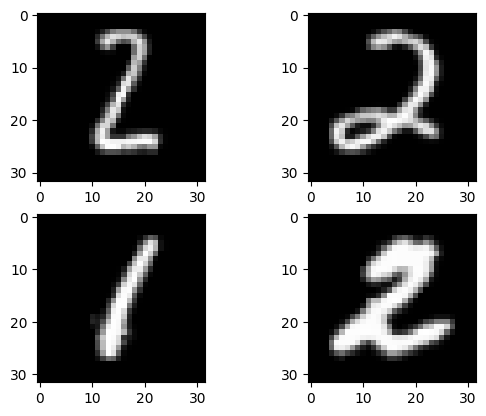

In [36]:

# download the MNIST dataset
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
batch_size = 64
train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


# Adjust subset size here, so you can reduce the training time
subset_size = int(0.1 * len(train))
indices = torch.randperm(len(train))[:subset_size]
train = Subset(train, indices)
subset_size = int(0.01 * len(test))
indices = torch.randperm(len(test))[:subset_size]
test = Subset(test, indices)    

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

# plot samples
num_samples = 2
sample_train = list(enumerate(train_loader))[0][1][0][:num_samples]
sample_test = list(enumerate(test_loader))[0][1][0][:num_samples]

fig, axs = plt.subplots(2, num_samples)
for i, sample in enumerate(sample_train):
    axs[0, i].imshow(sample.numpy().squeeze(), cmap='gray')
for i, sample in enumerate(sample_test):
    axs[1, i].imshow(sample.numpy().squeeze(), cmap='gray')


(array([626., 661., 614., 594., 553., 572., 608., 607., 567., 598.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

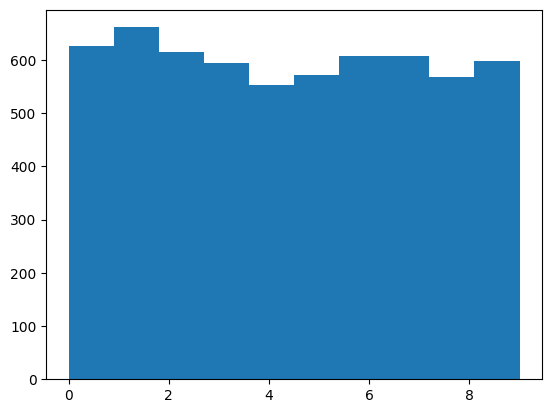

In [37]:
labels = []
for data in train:
    labels.append(data[1])
plt.hist(labels)

# Define Noising Function

In [38]:
start_alpha_t = 0.9999
end_alpha_t = 0.98
max_timestep = 1000
decrease_rate = (end_alpha_t - start_alpha_t) / max_timestep
alpha_t_list = torch.arange(start_alpha_t, end_alpha_t, decrease_rate).to(device)
alpha_hat_t_list = torch.cumprod(alpha_t_list, dim=0).to(device)

noise_scheduler = DDPMScheduler(num_train_timesteps=max_timestep)

def generate_noise_progression(X, times, noise):
    assert times.shape[0] == X.shape[0]
    return noise_scheduler.add_noise(X, noise, times)


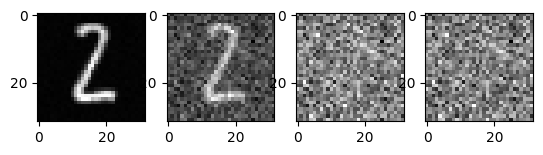

In [39]:
times = [0, 100, 500, 999]
noise = torch.randn(sample_train[0].shape).to(device)
noised_sample = generate_noise_progression(sample_train[0].unsqueeze(0).repeat(len(times), 1,1, 1).to(device), torch.tensor(times).to(device), noise)
fig, axs = plt.subplots(1, len(times))
for i, sample in enumerate(noised_sample):
    (axs[i].imshow(sample[0].detach().cpu().numpy(), cmap='gray'))


# Define Model

In [40]:
in_channels = 1
out_channels = 1
act_fn = "silu"
block_out_channels = (128, 128, 256, 256, 512, 512)
down_block_types = (
    "DownBlock2D",  
    "DownBlock2D",
    "DownBlock2D",
    "DownBlock2D",
    "AttnDownBlock2D", 
    "DownBlock2D",
)
up_block_types = (
    "UpBlock2D",
    "AttnUpBlock2D",
    "UpBlock2D",
    "UpBlock2D",
    "UpBlock2D",
    "UpBlock2D"
)
model = UNet2DModel(sample_size=32,
                     in_channels=in_channels,
                     out_channels=out_channels,
                     act_fn=act_fn,
                     block_out_channels=block_out_channels,
                     down_block_types=down_block_types,
                     up_block_types=up_block_types
                     ).to(device)

In [41]:
def generate_images(num_images, pipeline):
    return pipeline(batch_size=num_images).images

In [42]:
train_loss_evolution = []
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
num_epochs = 10

if os.path.exists("models/model.pth"):
    model  = torch.load("models/model.pth").to(device)
    print("Model already trained and loaded from file 'models/model.pth'")
    print("If you would like to retrain your model, delete 'models/model.pth' and run this cell again.")
else:
    model.train()
    for epoch in trange(num_epochs):
        train_loss = 0
        for i, (x, _) in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()
            times = torch.randint(2, max_timestep, size=(x.shape[0],)).to(device)
            noise = torch.randn(x.shape).to(device)
            noised_x = generate_noise_progression(x, times, noise)
            noise_pred = model(noised_x, times).sample
            
            loss = F.mse_loss(noise_pred, noise)
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
        average_train_loss = train_loss / len(train_loader)
        train_loss_evolution.append(average_train_loss)
        run.log({"epoch_train_loss": average_train_loss})        

100%|██████████| 10/10 [10:09<00:00, 60.97s/it]


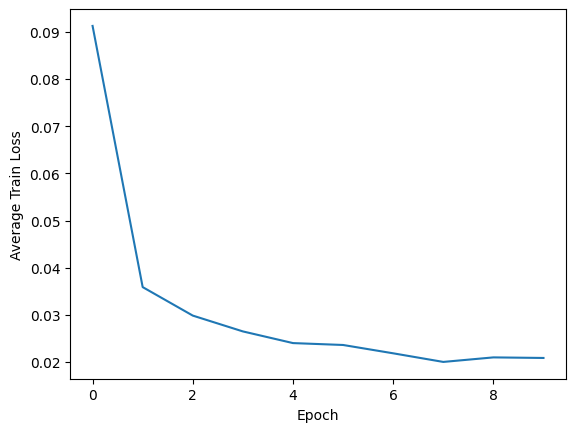

Model added to WandB - ArtifactManifestEntry(path='model.pth', digest='NuJ/fKcZJRAtlFas08LyQA==', size=454874466, local_path='/Users/varunchitturi/Library/Application Support/wandb/artifacts/staging/tmpzng61y1k', skip_cache=False)


In [43]:
# Log and show model and loss
if len(train_loss_evolution) != 0:
    model_artifact = wandb.Artifact(name="VDM",
                                    type="model",
                                    description="VDM using UNET to generate MNIST digits",
                                    metadata={
                                        "lr": lr,
                                        "num_epochs": num_epochs,
                                        "in_channels": in_channels,
                                        "out_channels": out_channels,
                                        "act_fn": act_fn,
                                        "block_out_channels": block_out_channels,
                                        "down_block_types": down_block_types,
                                        "up_block_types": up_block_types
                                    })
    fig, ax = plt.subplots()
    ax.plot(train_loss_evolution)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Average Train Loss")
    plt.show()
    pathlib.Path('./models').mkdir(exist_ok=True)
    torch.save(model, "models/model.pth")
    if model_artifact is not None:
        print(f"Model added to WandB - {model_artifact.add_file('./models/model.pth')}")

# Test

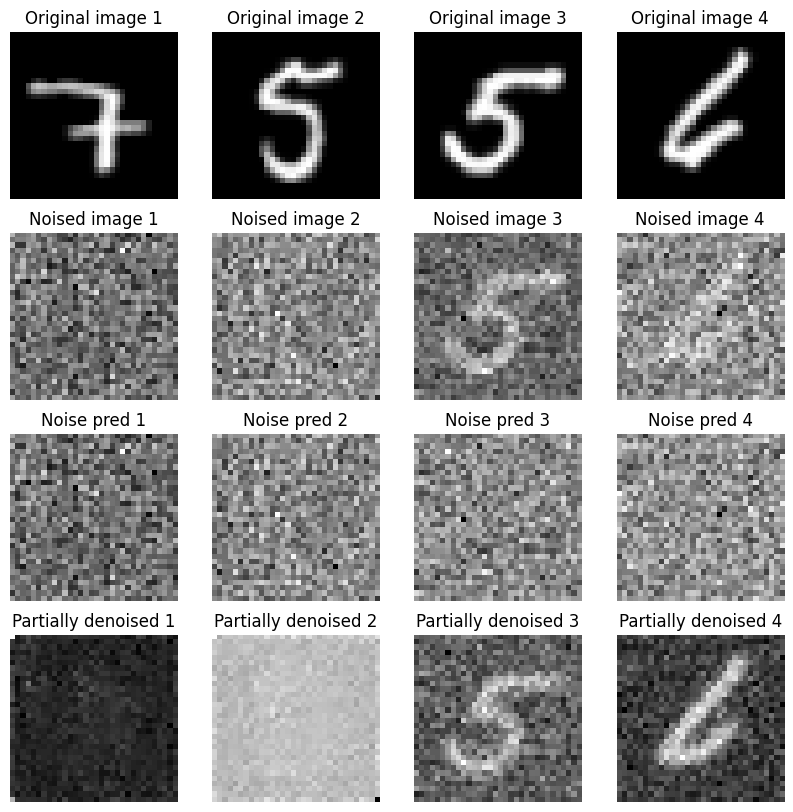

Iteration 0, Loss 0.026047255843877792
Iteration 1, Loss 0.020477913320064545
Average test loss: 0.02326258458197117


In [44]:
test_loss = 0
num_images = 4
fig, axs = plt.subplots(3, num_images, figsize=(10, 10))

model.eval()
for i, (x, _) in enumerate(test_loader):
    with torch.no_grad():
        x = x.to(device)
        times = torch.randint(2, max_timestep, size=(x.shape[0],)).to(device)
        noise = torch.randn(x.shape).to(device)
        noised_x = generate_noise_progression(x, times, noise)
        noise_pred = model(noised_x, times).sample
        loss = F.mse_loss(noise_pred, noise)
        test_loss += loss.item()
        if i == 0:
            x = x.detach().cpu().squeeze()
            noised_x = noised_x.detach().cpu().squeeze()
            noise_pred = noise_pred.detach().cpu().squeeze()
            for idx, ax in enumerate(axs[0]):
                ax.imshow(x[idx], cmap='gray')
                ax.axis('off')
                ax.set_title(f'Original image {idx + 1}')
            for idx, ax in enumerate(axs[1]):
                ax.imshow(noised_x[idx], cmap='gray')
                ax.axis('off')
                ax.set_title(f'Noised image {idx + 1}')
            for idx, ax in enumerate(axs[2]):
                ax.imshow(noise_pred[idx], cmap='gray')
                ax.axis('off')
                ax.set_title(f'Noise pred {idx + 1}')
            plt.show()
            run.log({"Original, Noised, Recon'd Images": fig})
    print("Iteration {}, Loss {}".format(i, loss.item()))
print(f'Average test loss: {test_loss / len(test_loader)}')

    

# Generate

In [48]:
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
generated_images = generate_images(100, pipeline)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

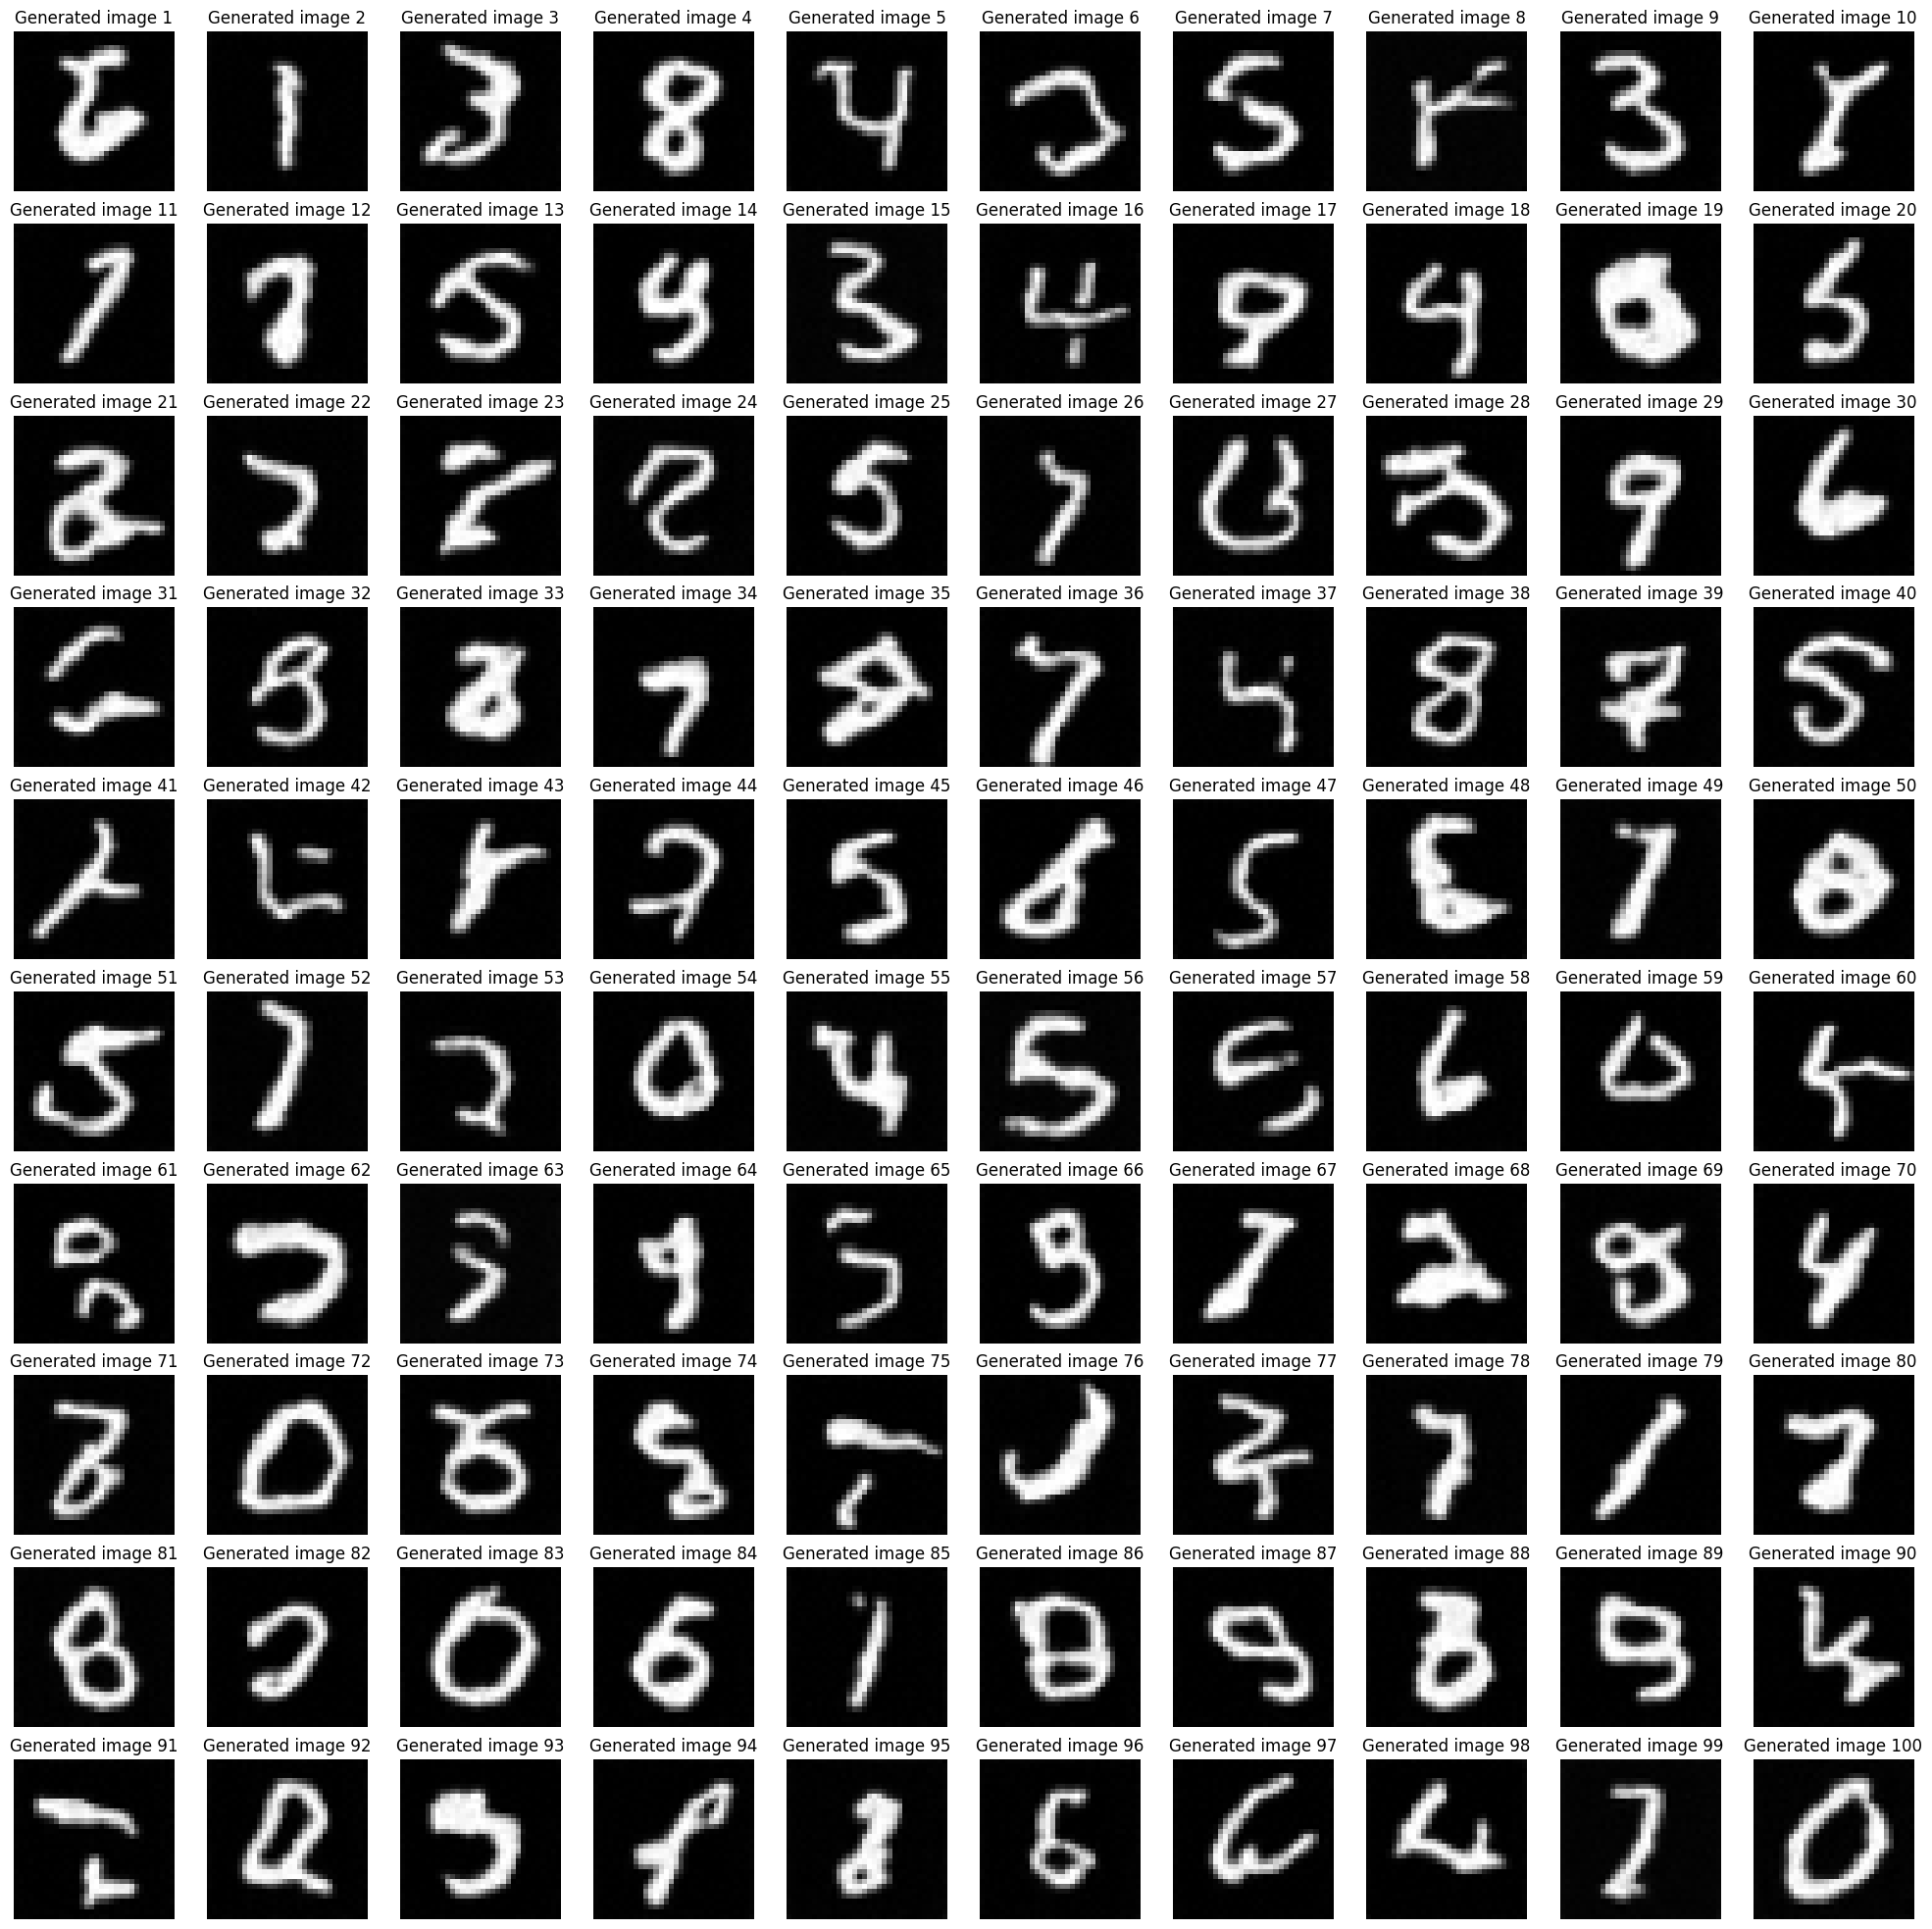

In [49]:
# Visualize the output
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(25, 25))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Generated image {idx + 1}')
plt.show()

In [47]:
run.log({"Generated Images": fig})
wandb.finish()

epoch_train_loss,█▃▂▂▁▁▁▁▁▁
epoch_train_loss,0.02086
